### Growth factor-mediated coupling between lineage size and cell fate choice underlies robustness of mammalian development

#### N. Saiz, L. Mora-Bitria, S. Rahman, H. George, J.P. Herder, J. García-Ojalvo and A.-K. Hadjantonakis

#### **Figure 3**

This code reproduces the effect of adding ESCs to the early embryo in our model of EPI-PrE cell fate choice. Running this code requires the C compiler `cc` and the utility `make`. Both are available by default in Linux, or by installing the `Xcode` development environment in Mac OS X.

First, we load all necessary packages:

In [1]:
import numpy as np
from IPython.display import clear_output
import subprocess
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20

Now we compile the C code:

In [2]:
try:
    out = subprocess.check_output('make --file=Makefile_v2 clean', shell=True)
    outlist = out.decode().split('\n')
    for outline in outlist:
        print(outline)
except:
    print('make failed')

p = subprocess.Popen(["make","--file=Makefile_v2"],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
while True:
    ln = p.stdout.readline().decode().rstrip()
    if ln == '':
            break
    print(ln)
while True:
    ln = p.stderr.readline().decode().rstrip()
    if ln == '':
            break
    print(ln)

rm *.o

cc -O3 -c dran.c -o dran.o
cc -O3 -c embryo_v2.c
cc embryo_v2.o dran.o -o embryo_v2 -lm


We now define a function `run` that generates the parameter value file and runs the C code. Some of the parameters are introduced as arguments to the function, the rest are hard-coded within it.

In [3]:
def run(nruns=10,alpha=10,Kf=1,nth=0.6,gth=0.4,n0=3,n0sd=0.5,N2add=2,t2start=40,sdt2start=0.02,
        mt=0.01,rntd=0.01,nth2=0.9,gth2=0.1,nESC=5,Nmax=50):
    fname = 'output/dset_v2_%i'%rngseed
    pfile = open(fname+'.par', 'w')
    pfile.write('%s    nruns\n'%nruns)
    pfile.write('1e-6    initial_mass\n')
    pfile.write('5.0    initial_radius\n')
    pfile.write('1e-6    effective_friction\n')
    pfile.write('1e-4    adhesion_strength\n')
    pfile.write('1.5    adhesion_strength_reduction_for_different_cell_types\n')
    pfile.write('2.0    adhesion_range\n')
    pfile.write('%s    alpha\n'%alpha)
    pfile.write('%s    Kf\n'%Kf)
    pfile.write('2    nh\n')
    pfile.write('2    mh\n')
    pfile.write('1.2    fd_FGF_range_factor\n')
    pfile.write('%s    nth_minimum_fraction_of_Nanog_max_for_EPI_allocation\n'%nth)
    pfile.write('%s    gth_maximum_fraction_of_Nanog_max_for_PrE_allocation\n'%gth)
    pfile.write('%s    nth2_maximum_Nanog_max_for_circuit_function\n'%nth2)
    pfile.write('%s    gth2_minimum_Nanog_max_for_circuit_function\n'%gth2)
    pfile.write('%s    maximum_cell_number\n'%Nmax)
    pfile.write('10         division_time\n')
    pfile.write('0.5         dispersion_in_division_time\n')
    pfile.write('100.0         final_time\n')
    pfile.write('%s          measuring_time\n'%mt)
    pfile.write('0.001        integration_time_step\n')
    pfile.write('%i          random_number_generator_seed\n'%rngseed)   #rng seed
    pfile.write('%s          initial_DC_Nanog\n'%n0)
    pfile.write('%s          initial_noise_Nanog\n'%n0sd)
    pfile.write('%s          division_noise\n'%rntd)  #0.01
    pfile.write('%s          cell_number_to_start_adding_ESCs\n'%N2add)
    pfile.write('%s          number_of_ESCs_to_add\n'%nESC)
    pfile.write('2.0         radius_of_ESCs\n')
    pfile.write('%s          time_to_start_biochemistry\n'%t2start)
    pfile.write('%s          std_time_to_start_biochemistry\n'%sdt2start)
    pfile.close()
    
    p = subprocess.Popen(['time','embryo_v2',fname],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    while True:
        ln = p.stdout.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)
    while True:
        ln = p.stderr.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)

Next we define the plotting function:

In [4]:
def plot_fractions_vs_time(nruns=1,title='',figname='', figtitle='',
                           tmin=40*90/56,tmax=60*90/56):
    tscale = 90/56
    fname = 'output/dset_v2_%i'%rngseed
    tvec = []
    fdpvec = []
    fepivec = []
    fprevec = []
    fescvec = []
    fdp2vec = []
    fepi2vec = []
    fpre2vec = []
    fesc2vec = []
    Nvec = []
    if nruns>1:
        sddpvec = []
        sdepivec = []
        sdprevec = []
        sdescvec = []
        sdNvec = []
    data = open(fname+'.dat', 'r')
    for it,line in enumerate(data):
        snap_raw = line.rstrip(' \n').split(' ')
        snap = np.array(list(map(float, snap_raw)))
        tvec.append(snap[0])
        fdpvec.append(snap[1]*100)
        fepivec.append(snap[2]*100)
        fprevec.append(snap[3]*100)
        fescvec.append(snap[4]*100)
        fdp2vec.append(snap[5]*100)
        fepi2vec.append(snap[6]*100)
        fpre2vec.append(snap[7]*100)
        fesc2vec.append(snap[8]*100)
        Nvec.append(snap[9])
        if nruns>1:
            sddpvec.append(np.sqrt(snap[5]-snap[1]**2)*100)
            sdepivec.append(np.sqrt(snap[6]-snap[2]**2)*100)
            sdprevec.append(np.sqrt(snap[7]-snap[3]**2)*100)
            sdescvec.append(np.sqrt(snap[8]-snap[4]**2)*100)
            sdNvec.append(np.sqrt(snap[10]-snap[9]**2))
    plt.figure()
    ax1 = plt.gca()
    if title != '':
        ax1.title(title,fontsize=15)
    ax2 = ax1.twinx()
    if nruns>1:
        ax1.errorbar(np.asarray(tvec)*tscale,fdpvec,yerr=sddpvec,capsize=4,fmt='om-',label='DP')
        ax1.errorbar(np.asarray(tvec)*tscale,fepivec,yerr=sdepivec,capsize=4,fmt='or-',label='EPI')
        ax1.errorbar(np.asarray(tvec)*tscale,fprevec,yerr=sdprevec,capsize=4,fmt='ob-',label='PrE')
        ax1.errorbar(np.asarray(tvec)*tscale,fescvec,yerr=sdprevec,capsize=4,fmt='o-',color=(0.84,0.99,0.37),label='ESC')
        ax2.errorbar(np.asarray(tvec)*tscale,Nvec,yerr=sdNvec,fmt='o-',color='grey',label='all')
    else:
        ax1.plot(np.asarray(tvec)*tscale,fdpvec,'m-',label='DP')
        ax1.plot(np.asarray(tvec)*tscale,fepivec,'r-',label='EPI')
        ax1.plot(np.asarray(tvec)*tscale,fprevec,'b-',label='PrE')
        ax1.plot(np.asarray(tvec)*tscale,fescvec,color=(0.84,0.99,0.37),label='ESC')
        ax2.plot(np.asarray(tvec)*tscale,Nvec,'grey',label='all')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc=2, fontsize=15)
    ax1.axhline(50,color='k',linestyle='--')
    ax1.set_xlabel('time (hpf)')
    ax1.set_ylabel('% of ICM')
    ax1.set_xlim([tmin,tmax])
    ax1.set_ylim([-2,102])
    ax2.set_ylabel('cell number', rotation=270, labelpad=20, color='grey')
    ax2.tick_params(axis='y', colors='grey')
    plt.title(figtitle)
    plt.tight_layout()
    if figname == '':
        figname = 'single_run'
    plt.savefig('figures/fig3g_%s.pdf'%figname)
    plt.show()

Using the functions defined above, now we study the response of the developing embryo to cell addition. First we run single realizations of the simulation for two different numbers of ESCs.

        0.48 real         0.35 user         0.00 sys


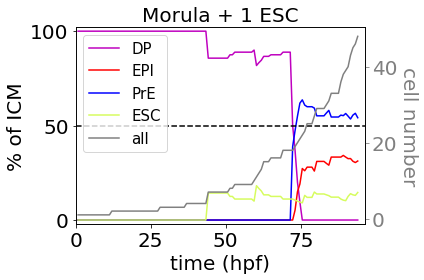

In [5]:
nruns = 1
rngseed = 1235

run(nruns=nruns, alpha=10, Kf=0.9, nth=0.8, gth=0.2, n0=3,
    n0sd=0, N2add=5, t2start=45, mt=0.5, nESC=1, Nmax=50)

plot_fractions_vs_time(nruns=nruns, tmin=0,
                       figname='1_ESC', figtitle='Morula + 1 ESC')

        0.33 real         0.30 user         0.00 sys


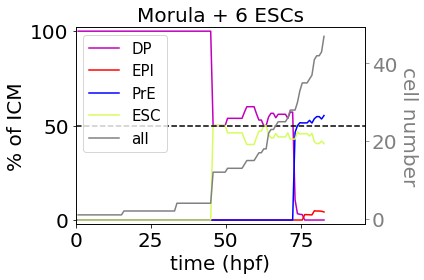

In [6]:
nruns = 1
rngseed = 1246

run(nruns=nruns, alpha=10, Kf=0.9, nth=0.8, gth=0.2, n0=3,
    n0sd=0, N2add=5, t2start=45, mt=0.5, nESC=6, Nmax=50)

plot_fractions_vs_time(nruns=nruns, tmin=0,
                       figname='6_ESCs', figtitle='Morula + 6 ESCs')

In [7]:
def run_scan(nruns=1,alpha=10,Kf=0.9,nth=0.8,gth=0.2,n0=3,n0sd=0,
             N2add=5,t2start=45,sdt2start=0.02,mt=0.01,rntd=0.01,
             nth2=0.9,gth2=0.1,nESC=5,Nmax=200,tsim=60):
    fname = 'output/dset_v2_scan'
    pfile = open(fname+'.par', 'w')
    pfile.write('%s    nruns\n'%nruns)
    pfile.write('1e-6    initial_mass\n')
    pfile.write('5.0    initial_radius\n')
    pfile.write('1e-6    effective_friction\n')
    pfile.write('1e-4    adhesion_strength\n')
    pfile.write('1.5    adhesion_strength_reduction_for_different_cell_types\n')
    pfile.write('2.0    adhesion_range\n')
    pfile.write('%s    alpha\n'%alpha)
    pfile.write('%s    Kf\n'%Kf)
    pfile.write('2    nh\n')
    pfile.write('2    mh\n')
    pfile.write('1.2    fd_FGF_range_factor\n')
    pfile.write('%s    nth_minimum_fraction_of_Nanog_max_for_EPI_allocation\n'%nth)
    pfile.write('%s    gth_maximum_fraction_of_Nanog_max_for_PrE_allocation\n'%gth)
    pfile.write('%s    nth2_maximum_Nanog_max_for_circuit_function\n'%nth2)
    pfile.write('%s    gth2_minimum_Nanog_max_for_circuit_function\n'%gth2)
    pfile.write('%s    maximum_cell_number\n'%Nmax)
    pfile.write('10         division_time\n')
    pfile.write('0.5         dispersion_in_division_time\n')
    pfile.write('%s         final_time\n'%tsim)
    pfile.write('%s          measuring_time\n'%mt)
    pfile.write('0.001        integration_time_step\n')
    pfile.write('%i          random_number_generator_seed\n'%rngseed)   #rng seed
    pfile.write('%s          initial_DC_Nanog\n'%n0)
    pfile.write('%s          initial_noise_Nanog\n'%n0sd)
    pfile.write('%s          division_noise\n'%rntd)  #0.01
    pfile.write('%s          cell_number_to_start_adding_ESCs\n'%N2add)
    pfile.write('%s          number_of_ESCs_to_add\n'%nESC)
    pfile.write('2.0         radius_of_ESCs\n')
    pfile.write('%s          time_to_start_biochemistry\n'%t2start)
    pfile.write('%s          std_time_to_start_biochemistry\n'%sdt2start)
    pfile.close()

    p = subprocess.Popen(['embryo_v2',fname],stdout=subprocess.PIPE,
                         stderr=subprocess.PIPE)
    while True:
        ln = p.stdout.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)
    while True:
        ln = p.stderr.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)

    data = open(fname+'.dat', 'r')
    for it,line in enumerate(data):
        snap_raw = line.rstrip(' \n').split(' ')
        snap = np.array(list(map(float, snap_raw)))
    fdp = snap[1]*100
    fepi = snap[2]*100
    fpre = snap[3]*100
    fesc = snap[4]*100
    N = snap[9]
        
    return [N,fdp,fepi,fpre,fesc]

In [8]:
Nvec = []
fdpvec = []
fepivec = []
fprevec = []
fescvec = []
nescini = []
tmax = 118*56/90
for i in range(8):
    nESC = i+1
    print('number of added ESCs =',nESC)
    for j in range(20):
        print('-> run %i/20'%(j+1), end='\r', flush=True)
        rngseed = 111*i+j
        [N,fdp,fepi,fpre,fesc] = run_scan(nESC=nESC,Nmax=200,tsim=tmax)
        Nvec.append(N)
        fdpvec.append(fdp)
        fepivec.append(fepi)
        fprevec.append(fpre)
        fescvec.append(fesc)
        nescini.append(nESC)

number of added ESCs = 1
number of added ESCs = 2
number of added ESCs = 3
number of added ESCs = 4
number of added ESCs = 5
number of added ESCs = 6
number of added ESCs = 7
number of added ESCs = 8


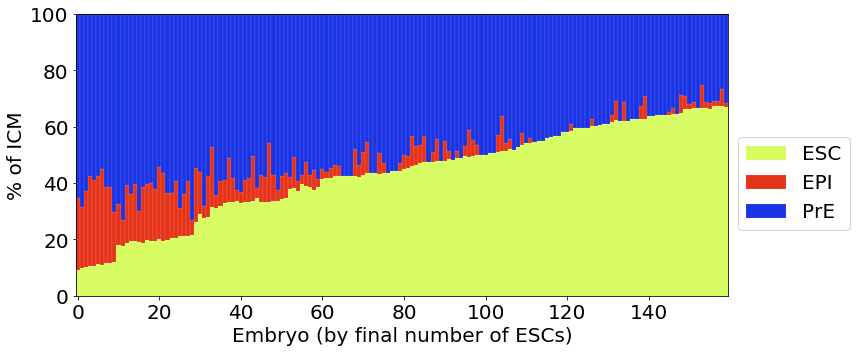

In [9]:
nescvec = np.asarray(fescvec)*np.asarray(Nvec)
inds = np.argsort(nescvec)

sortednesc = np.zeros_like(nescvec)
sortedfdp = np.zeros_like(fdpvec)
sortedfepi = np.zeros_like(fepivec)
sortedfpre = np.zeros_like(fprevec)
sortedfesc = np.zeros_like(fescvec)
for i,ind in enumerate(inds):
    sortednesc[i] = nescvec[ind]
    sortedfdp[i] = fdpvec[ind]
    sortedfepi[i] = fepivec[ind]
    sortedfpre[i] = fprevec[ind]
    sortedfesc[i] = fescvec[ind]

width = 1
plt.figure(figsize=(12,5))
p1 = plt.bar(range(len(nescvec)),sortedfesc,
             width, color=(0.84,0.99,0.37),
             edgecolor='white', linewidth=0.1)
p2 = plt.bar(range(len(nescvec)),sortedfepi,
             width, bottom=sortedfesc, color='#e5331a',
             edgecolor='white', linewidth=0.1) 
p4 = plt.bar(range(len(nescvec)), sortedfpre, width,
             bottom=sortedfesc+sortedfepi+sortedfdp, color='#1a33e5',
             edgecolor='white', linewidth=0.1)
plt.xlabel('Embryo (by final number of ESCs)')
plt.ylabel('% of ICM')
plt.ylim([0,100])
plt.xlim(-0.5,159.5)
#plt.title('100% EPI ablation')
plt.legend((p1[0], p2[0], p4[0]), ('ESC','EPI','PrE'),bbox_to_anchor=(1, 0.6))
plt.tight_layout()
plt.savefig('figures/fig3h_scan.pdf')
plt.show()